In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 5
%autosave 15

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import log_loss, accuracy_score
from sklearn.cross_validation import cross_val_score, train_test_split

Autosaving every 15 seconds


In [2]:
# load data
data = pd.read_csv('data.csv')

total_actions = dict(data.action_type.value_counts())
# TODO: tune this parameter
threshold = 100
# TODO: check if it's needed
data['type'] = data.apply(lambda row: row['action_type'] if total_actions[row['action_type']] >= threshold \
                          else row['combined_shot_type'], axis=1)
data['time_remaining'] = data.apply(lambda row: row['minutes_remaining'] * 60 + row['seconds_remaining'], axis=1)

# TODO: tune this parameter
threshold = 3
# TODO: find out why he cant hit @ 14 secs to go
anomaly = 14
data['last_moment'] = data.apply(lambda row: row['time_remaining'] < threshold or row['time_remaining'] == anomaly, axis=1)
data['away'] = data.matchup.str.contains('@')
data['season'] = data.apply(lambda row: int(row['season'].split('-')[0]), axis=1)

# remove outliers
data['shot_distance'] = data.apply(lambda row: 28 if row['shot_distance'] > 28 else row['shot_distance'], axis=1)

def get_acc(data, field):
    ct = pd.crosstab(data.shot_made_flag, data[field]).apply(lambda x: x / x.sum(), axis=0)
    x, y = ct.columns, ct.values[1, :]
    plt.figure(figsize=(7, 5))
    plt.plot(x, y)
    plt.xlabel(field)
    plt.ylabel('% shots made')
    plt.show()
    
def sort_encode(data, field):
    ct = pd.crosstab(data.shot_made_flag, data[field]).apply(lambda x: x / x.sum(), axis=0)
    temp = list(zip(ct.values[1, :], ct.columns))
    temp.sort()
    new_map = {}
    for index, (acc, old_number) in enumerate(temp):
        new_map[old_number] = index
    new_field = field + '_sort_enumerated'
    data[new_field] = data[field].map(new_map)
    get_acc(data, new_field)

data.drop([
        'action_type',
        'combined_shot_type',
        'game_event_id',
        'game_id',
        'lat',
        'lon',
        'minutes_remaining',
        'seconds_remaining',
        'time_remaining',
        'team_id',
        'team_name',
        'matchup',
        'game_date',
        'shot_type',
        'playoffs',
        'season',
        # TODO: find out whether these two features matter or not
        'loc_x',
        'loc_y',
    ], axis=1, inplace=True)

dummies = [
    'period',
    'type',
    'shot_zone_area',
    'shot_zone_basic',
    'shot_zone_range',
    'opponent', #TODO: check if it's needed
]
dummie_counter = {}
for dummy in dummies:
    dummie_counter[dummy] = len(data[dummy].unique())
data = pd.get_dummies(data, columns=dummies)
data.head()

,shot_distance,shot_made_flag,shot_id,last_moment,away,period_1,period_2,period_3,period_4,period_5,...,opponent_PHI,opponent_PHX,opponent_POR,opponent_SAC,opponent_SAS,opponent_SEA,opponent_TOR,opponent_UTA,opponent_VAN,opponent_WAS
0,18,NaN,1,False,True,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,15,0.0,2,False,True,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,16,1.0,3,False,True,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,22,0.0,4,False,True,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,1.0,5,False,True,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
for col in data.columns.tolist():
    if col not in ['shot_made_flag', 'shot_id']:
        print(col + ': ' + str(len(data[col].unique())))

shot_distance: 29
last_moment: 2
away: 2
period_1: 2
period_2: 2
period_3: 2
period_4: 2
period_5: 2
period_6: 2
period_7: 2
type_Alley Oop Dunk Shot: 2
type_Bank Shot: 2
type_Driving Dunk Shot: 2
type_Driving Layup Shot: 2
type_Dunk: 2
type_Dunk Shot: 2
type_Fadeaway Jump Shot: 2
type_Floating Jump shot: 2
type_Hook Shot: 2
type_Jump Bank Shot: 2
type_Jump Shot: 2
type_Layup: 2
type_Layup Shot: 2
type_Pullup Jump shot: 2
type_Reverse Layup Shot: 2
type_Running Jump Shot: 2
type_Slam Dunk Shot: 2
type_Step Back Jump shot: 2
type_Tip Shot: 2
type_Turnaround Fadeaway shot: 2
type_Turnaround Jump Shot: 2
shot_zone_area_Back Court(BC): 2
shot_zone_area_Center(C): 2
shot_zone_area_Left Side Center(LC): 2
shot_zone_area_Left Side(L): 2
shot_zone_area_Right Side Center(RC): 2
shot_zone_area_Right Side(R): 2
shot_zone_basic_Above the Break 3: 2
shot_zone_basic_Backcourt: 2
shot_zone_basic_In The Paint (Non-RA): 2
shot_zone_basic_Left Corner 3: 2
shot_zone_basic_Mid-Range: 2
shot_zone_basic_Res

In [4]:
# split into train and test
train = data[~data['shot_made_flag'].isnull()]
test = data[data['shot_made_flag'].isnull()]
print('train size: ' + str(len(train)))
print('test size:  ' + str(len(test)))

# prepare data for estimators
target = 'shot_made_flag'
features = data.columns.tolist()
features.remove(target)
features.remove('shot_id')
X_test = test[features]
X_train = train[features]
y_train = train[[target]]['shot_made_flag'].values
print(X_train.shape)
print(y_train.shape)

train size: 25697
test size:  5000
(25697, 82)
(25697,)


In [5]:
def modelfit(alg, dtrain, predictors, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
                          early_stopping_rounds=early_stopping_rounds, metrics=['logloss'], show_progress=False)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    # Test params
    X_train, X_valid, y_train, y_valid = train_test_split(dtrain[predictors], dtrain[target], test_size=0.2)
    alg.fit(X_train, y_train, eval_metric='logloss')
    y_pred = alg.predict_proba(X_valid)[:,1]
    
    result = log_loss(y_valid, y_pred)
    print(result)
    return result

Will train until cv error hasn't decreased in 50 rounds.


0.601607967617


Will train until cv error hasn't decreased in 50 rounds.
Stopping. Best iteration: 134


0.601530414511


Will train until cv error hasn't decreased in 50 rounds.
Stopping. Best iteration: 105


0.601412305185


Will train until cv error hasn't decreased in 50 rounds.
Stopping. Best iteration: 86


0.602243688355


Will train until cv error hasn't decreased in 50 rounds.
Stopping. Best iteration: 73


0.60334081232


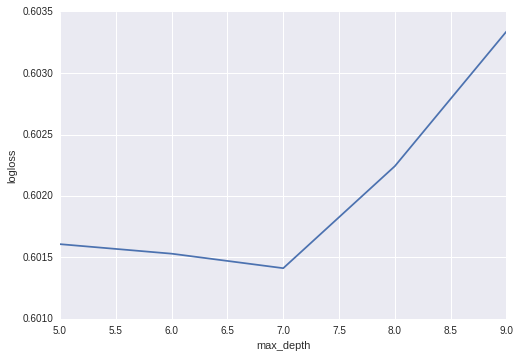

In [6]:
params = {
    'base_score': 0.5, 
    'colsample_bylevel': 1,
    'colsample_bytree': 0.8,
    'learning_rate': 0.05,
    'max_depth': 6,
    'min_child_weight': 1,
    'n_estimators': 200,
    'nthread': -1,
    'objective': 'binary:logistic',
    'seed': 27,
    'silent': True,
    'subsample': 0.8
}
clf = xgb.XGBClassifier()

logloss = []
tuning_param = 'max_depth'
param_values = range(5, 10)
for i in param_values:
    params[tuning_param] = i
    clf.set_params(**params)
    logloss.append(modelfit(clf, train, features))
plt.plot(param_values, logloss)
plt.xlabel(tuning_param)
plt.ylabel('logloss')

In [7]:
# fit, predict and generate submission file
clf = xgb.XGBClassifier()
clf.set_params(**params)
clf.fit(X_train, y_train)
test.shot_made_flag = [i[1] for i in clf.predict_proba(X_test)]
test[['shot_id', 'shot_made_flag']].to_csv('sub.csv', index=False)

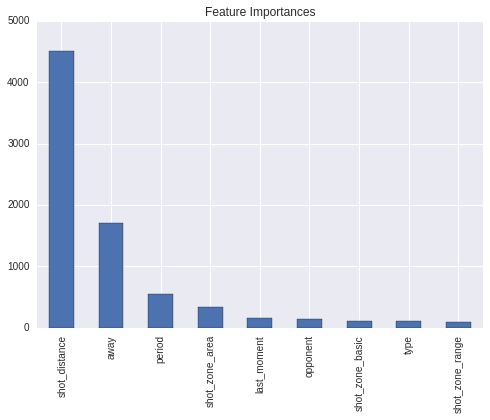

In [8]:
# display feature importances
# TODO: prettify this code
feature_importances = clf.booster().get_fscore()
to_pop = []
for dummie in dummies:
    feature_importances[dummie] = 0
for feature in feature_importances:
    for dummie in dummies:
        if feature.startswith(dummie) and feature not in dummies:
            feature_importances[dummie] += feature_importances[feature]
            to_pop.append(feature)
for feature in to_pop:
    feature_importances.pop(feature, None)
for dummie in dummies:
    feature_importances[dummie] /= dummie_counter[dummie]
feat_imp = pd.Series(feature_importances).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')